<a href="https://colab.research.google.com/github/ysk-cu/MECE4305_LEO_to_MARS/blob/main/Mission_definition_cooling_Turbopump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
!pip install cantera CoolProp -q

In [2]:
# Mission delta-V segments (km/s)
dv_LEO_to_Mars_transfer = 3.6   # LEO -> TMI
dv_Mars_transfer_to_Mars_orbit = 2.11   # capture / insertion
dv_Mars_orbit_to_surface = 3.6   # deorbit + descent + landing


def isp(dv, m0, mf, g0=9.80665):
    """Compute effective specific impulse (s) for a given delta-V and mass ratio."""
    return dv * 1000.0 / (g0 * math.log(m0 / mf))


# --- Mass model (simple, 1-stage equivalent for now) ---
mpayload = 100000      # kg
mstarship = 100000     # kg
# msuperheavy = 200000   # kg
mfuel_starship = 1500000      # kg
# mfuel_superheavy = 3400000    # kg
# mprop_landing = 150000      # kg of propellant reserved for Mars landing

# m0 = mpayload + mstarship + mfuel_starship + mprop_landing    # initial mass (LEO)
m0 = mpayload + mstarship + mfuel_starship    # initial mass (LEO)
mf = mpayload + mstarship      # final mass after all propellant is burned (simplified)

# Total mission delta-V (no aerocapture)
dv_total = dv_Mars_transfer_to_Mars_orbit + dv_LEO_to_Mars_transfer + dv_Mars_orbit_to_surface

# Alternative with aerocapture (no Mars orbit insertion burn)
dv_air_capture = dv_LEO_to_Mars_transfer + 1.03848 + 0.0125 #km/s

Isp = isp(dv_total, m0, mf)
Isp_air_capture = isp(dv_air_capture, m0, mf)

print("Delta-V requirements for Mars mission:")
print(f"  deltaV without air capture: {dv_total:.2f} km/s")
print(f"  deltaV with air capture: {dv_air_capture:.2f} km/s")
print(f"  Effective Isp required (no aerocapture): {Isp:.2f} s")
print(f"  Effective Isp required (with aerocapture): {Isp_air_capture:.2f} s")

# --- Weights and thrust-to-weight ratios ---

g_earth = 9.80665  # m/s^2
g_mars = 3.72076   # m/s^2

W_e = m0 * g_earth
# m_landing = mpayload + mstarship + mprop_landing
m_landing = mpayload + mstarship
W_m = m_landing * g_mars

print("\nWeights:")
print(f"  Weight in LEO at start (Earth g): {W_e:.2f} N")
print(f"  Weight on Mars after landing (Mars g, using mf): {W_m:.2f} N")

# # Thrust model (Raptors)
# T_raptor = 2255529.5  # N (approx vacuum thrust per engine)
# n_raptor_booster = 6
# T_total_booster = n_raptor_booster * T_raptor

# Approximate Starship thrust (vacuum Raptor cluster)
T_starship = 14709975  # N (100% thrust cluster)

# TWR_launch = T_total_booster / W_e
T_landing = 0.4 * T_starship #???
TWR_landing = T_landing / W_m

# print("\nThrust-to-weight ratios:")
# print(f"  TWR at launch (Super Heavy in LEO, using Earth g): {TWR_launch:.2f}")
print(f"T_starship: {T_starship}")
print(f"T_landing: {T_landing}")

print(f"  TWR at Mars landing (Starship vs W_m): {TWR_landing:.2f}")



Delta-V requirements for Mars mission:
  deltaV without air capture: 9.31 km/s
  deltaV with air capture: 4.65 km/s
  Effective Isp required (no aerocapture): 443.61 s
  Effective Isp required (with aerocapture): 221.61 s

Weights:
  Weight in LEO at start (Earth g): 16671305.00 N
  Weight on Mars after landing (Mars g, using mf): 744152.00 N
T_starship: 14709975
T_landing: 5883990.0
  TWR at Mars landing (Starship vs W_m): 7.91


In [3]:
def calculate_burn_time(delta_v_km_s, m0_kg, thrust_n, isp_s, g0=9.80665):
    """
    Calculates the burn time required to achieve a given Delta-V
    assuming constant thrust.
    """
    # Convert Delta-V to m/s
    dv = delta_v_km_s * 1000.0

    # Effective Exhaust Velocity (Ve)
    ve = isp_s * g0

    # 1. Calculate Mass Ratio required for this Delta-V
    # mass_ratio = m_initial / m_final = exp(dv / ve)
    mass_ratio = math.exp(dv / ve)

    # 2. Calculate Propellant Mass required
    # m_final = m0 / mass_ratio
    # m_prop = m0 - m_final
    m_final = m0_kg / mass_ratio
    m_prop = m0_kg - m_final

    # 3. Calculate Mass Flow Rate (mdot)
    # F = mdot * ve  =>  mdot = F / ve
    mdot = thrust_n / ve

    # 4. Burn Time
    if mdot == 0: return float('inf')
    t_burn = m_prop / mdot

    return t_burn, m_prop, mdot

In [4]:
# m_starship_initial = 1320000.0  # kg (Full propellant + payload)
dv_tmi = 3.6                    # km/s (Target)
dv_orbit = 1.0348
dv_aerobrake_walkin = 0.0125
# isp_vac = 380                # s (Raptor Vacuum)
# isp_vac = 352.7                   # s (Engine Analysis ideal isp result.prof)
# isp_vac = 335.1                   # s (Engine Analysis effective isp result.prof)
isp_vac = 342.1 # s (film cooling considered)
# isp_tmi = isp(dv_tmi, m0, 163.8)
thrust_starship = 7590347.1 # N ( 3 vacuum engines * 2.53 MN)

_,_,mdot = calculate_burn_time(dv_tmi, m0, thrust_starship, isp_vac)
print(f"mdot_total:{mdot}")

t_tmi, prop_tmi_used, mdot = calculate_burn_time(dv_tmi, m0, thrust_starship, isp_vac)
# t_tmi_m, prop_tmi_used_m = calculate_burn_time(dv_tmi, m0, thrust_starship, isp_tmi)

m_orbit = m0 - prop_tmi_used
t_orbit, prop_orbit_used, mdot = calculate_burn_time(dv_orbit, m_orbit, thrust_starship, isp_vac)

m_aerobrake_walkin = m_orbit - prop_orbit_used

# isp_orbit = isp(dv_orbit, m_orbit, m_aerobrake_walkin, )
# t_orbit_m, prop_orbit_used_m = calculate_burn_time(dv_orbit, m_orbit, thrust_starship, isp_orbit)

t_aero, prop_aero_used,mdot = calculate_burn_time(dv_aerobrake_walkin, m_aerobrake_walkin, thrust_starship, isp_vac)

# m_landing = m_aerobrake_walkin - prop_aero_used

# isp_aero = isp(dv_aerobrake_walkin, m_aerobrake_walkin, m_landing)
# t_aero_m, prop_aero_used_m = calculate_burn_time(dv_aerobrake_walkin, m_aerobrake_walkin, thrust_starship, isp_aero)



print("------- # 1. LEO to TMI -------")
print(f"Target Delta-V: {dv_tmi} km/s")
print(f"Required Propellant: {prop_tmi_used/1000:.1f} tons")
print(f"Burn Time: {t_tmi:.1f} seconds ({t_tmi/60:.1f} minutes ({t_tmi/3600:.1f} hours))")
# print(f"Mission Propellant: {prop_tmi_used_m/1000:.1f} tons")
# print(f"Mission Burn Time: {t_tmi_m:.1f} seconds ({t_tmi_m/60:.1f} minutes) ({t_tmi_m/3600:.1f} hours)\n")

print("------- # 2. TMI to Orbit -------")
print(f"Target Delta-V: {dv_orbit} km/s")
print(f"Required Propellant: {prop_orbit_used/1000:.1f} tons")
print(f"Burn Time: {t_orbit:.1f} seconds ({t_orbit/60:.1f} minutes) ({t_orbit/3600:.1f} hours)")
# print(f"Mission Propellant: {prop_orbit_used_m/1000:.1f} tons")
# print(f"Mission Burn Time: {t_orbit_m:.1f} seconds ({t_orbit_m/60:.1f} minutes)\n")

print("------- # 3. Orbit to Aerobrake walk-in -------")
print(f"Target Delta-V: {dv_aerobrake_walkin} km/s")
print(f"Required Propellant: {prop_aero_used/1000:.1f} tons")
print(f"Burn Time: {t_aero:.1f} seconds ({t_aero/60:.1f} minutes) ({t_aero/3600:.1f} hours)")
# print(f"Mission Propellant: {prop_aero_used_m/1000:.1f} tons")
# print(f"Mission Burn Time: {t_aero_m:.1f} seconds ({t_aero_m/60:.1f} minutes)\n")

print("\n")
print(f"Total required fuel consumption:{(prop_tmi_used+prop_orbit_used+prop_aero_used)/1000} tons")
print(f"Available fuel for landing:{1500-(prop_tmi_used+prop_orbit_used+prop_aero_used)/1000} tons")

mdot_total:2262.4963460976323
------- # 1. LEO to TMI -------
Target Delta-V: 3.6 km/s
Required Propellant: 1118.7 tons
Burn Time: 494.4 seconds (8.2 minutes (0.1 hours))
------- # 2. TMI to Orbit -------
Target Delta-V: 1.0348 km/s
Required Propellant: 154.3 tons
Burn Time: 68.2 seconds (1.1 minutes) (0.0 hours)
------- # 3. Orbit to Aerobrake walk-in -------
Target Delta-V: 0.0125 km/s
Required Propellant: 1.6 tons
Burn Time: 0.7 seconds (0.0 minutes) (0.0 hours)


Total required fuel consumption:1274.5542863372732 tons
Available fuel for landing:225.4457136627268 tons


In [6]:
# # --- LEO to TMI burn performance ---

# a_LEO_to_TMI = dv_LEO_to_Mars_transfer * 1000.0 / t_burn_LEO_to_TMI  # m/s^2
# T_req_LEO_to_TMI = a_LEO_to_TMI * m0
# TWR_req_LEO_to_TMI = T_req_LEO_to_TMI / W_e

# print("\nLEO to TMI burn:")
# print(f"  Assumed burn time: {t_burn_LEO_to_TMI} s")
# print(f"  Average acceleration: {a_LEO_to_TMI:.2f} m/s^2")
# print(f"  Thrust required: {T_req_LEO_to_TMI:.2f} N")
# print(f"  Equivalent TWR during burn: {TWR_req_LEO_to_TMI:.2f}")

# """
# TMI to Mars orbit
# """

# # --- Mars orbit to surface (landing) performance ---

# # For landing, we use mf as an approximate mass at the start of the landing burn (simplified).
# # You can refine this later by subtracting remaining propellant if needed.

# t_burn_landing = 8 * 60  # s (assumed duration of powered descent)

# a_landing = dv_Mars_orbit_to_surface * 1000.0 / t_burn_landing
# T_req_landing = a_landing * mf
# TWR_req_landing = T_req_landing / W_m

# print("\nMars landing burn (Mars orbit to surface):")
# print(f"  Assumed burn time: {t_burn_landing} s")
# print(f"  Average acceleration: {a_landing:.2f} m/s^2")
# print(f"  Thrust required: {T_req_landing:.2f} N")
# print(f"  Required TWR during landing burn: {TWR_req_landing:.2f}")
# print(f"  Available TWR at 40% throttle (vs W_m): {TWR_landing:.2f}")

In [7]:
import cantera as ct
from CoolProp.CoolProp import PropsSI
import math
# 코드 맨 위에 추가
from scipy.optimize import brentq
from typing import Dict, Tuple

class FFSC_FilmCooling_Solver:
    def __init__(self):
        # --- [1] Target & Propellants ---
        self.thrust_kN = 2530.0
        self.isp_s = 380 # (User Provided Value)
        self.pc_bar = 300.0
        self.of_ratio = 3.8
        self.fuel_coolprop = "Methane"
        self.ox_coolprop = "Oxygen"
        self.fuel_name = "CH4"  # Cantera Species Name
        self.ox_name = "O2"     # Cantera Species Name
        self.mech_file = 'gri30.yaml'
        self.T_fuel_tank = 110.0
        self.T_ox_tank = 90.0
        self.isp_s = 352.7

        # --- [2] Film Cooling Setting ---
        self.film_cooling_pct = 6.0  # %

        # --- [3] Nozzle & Channel Geometry ---
        self.nozzle_length_m = 3.1
        self.n_channels = 100
        self.w_channel_mm = 6.0
        self.h_channel_mm = 10.0
        self.roughness_mm = 0.005

        # 냉각재 온도 상승 가정 (dP 계산용)
        self.coolant_temp_rise = 200.0

        # --- [4] Losses & Efficiencies ---
        self.injector_dp_frac = 0.20
        self.feed_line_dp_bar = 10.0

        self.eta_pump = 0.75
        self.eta_turb = 0.85
        self.eta_mech = 0.95

        self.pr_fuel_turb = 1.8
        self.pr_ox_turb = 1.45

        self.max_wall_temp_K = 900.0


    def get_transport_properties(self, fluid, T_K, P_bar):
        """CoolProp에서 밀도(D)와 점성(V)을 가져옴"""
        rho = PropsSI('D', 'T', T_K, 'P', P_bar * 1e5, fluid)
        mu = PropsSI('V', 'T', T_K, 'P', P_bar * 1e5, fluid)
        return rho, mu

    def calculate_cooling_dp(self, m_dot_cool_kg_s, P_inlet_bar):
        """채널 형상과 유량을 기반으로 압력 강하(dP) 계산"""
        w = self.w_channel_mm / 1000.0
        h = self.h_channel_mm / 1000.0
        L = self.nozzle_length_m

        A_channel = w * h
        A_total = A_channel * self.n_channels
        perimeter = 2 * (w + h)
        D_h = (4 * A_channel) / perimeter

        T_bulk = self.T_fuel_tank + (self.coolant_temp_rise / 2.0)

        try:
            rho_avg, mu_avg = self.get_transport_properties(self.fuel_coolprop, T_bulk, P_inlet_bar)
        except:
            rho_avg = 350.0
            mu_avg = 1.5e-5

        velocity = m_dot_cool_kg_s / (rho_avg * A_total)
        Re = (rho_avg * velocity * D_h) / mu_avg

        epsilon = (self.roughness_mm / 1000.0) / D_h
        if Re < 2300:
            f = 64.0 / Re
        else:
            term = (epsilon/3.7)**1.11 + (6.9/Re)
            f = 1.0 / (-1.8 * math.log10(term))**2

        dp_pa = f * (L / D_h) * (0.5 * rho_avg * velocity**2)
        dp_bar = dp_pa / 1e5

        return dp_bar, velocity, Re, T_bulk

    def solve_turbine_req_T(self, target_power_W, m_dot, P_in_bar, P_out_bar, species_dict):
        """
        [새로 추가된 기능]
        터빈이 목표 동력(Power)을 내기 위해 필요한 입구 온도를 역산하는 함수 (Bisection Method)
        """
        T_min, T_max = 100.0, 2000.0 # 탐색 범위 (K)

        for i in range(30): # 30회 반복
            T_guess = (T_min + T_max) / 2.0

            # 1. State 1: Turbine Inlet
            gas = ct.Solution(self.mech_file)
            gas.TPX = T_guess, P_in_bar * 1e5, species_dict
            gas.equilibrate('TP')
            h1 = gas.enthalpy_mass
            s1 = gas.entropy_mass

            # 2. State 2s: Isentropic Expansion
            gas.SPX = s1, P_out_bar * 1e5, species_dict
            gas.equilibrate('SP')
            h2s = gas.enthalpy_mass

            # 3. Actual Work Calculation
            # W_actual = (h1 - h2s) * eta_turb * eta_mech * m_dot
            d_h_ideal = h1 - h2s
            d_h_actual = d_h_ideal * self.eta_turb
            power_calc = d_h_actual * m_dot * self.eta_mech

            # 4. Convergence Check
            if abs(power_calc - target_power_W) < 1000.0: # 1kW 오차 이내
                return T_guess, gas.cp_mass, gas.cp/gas.cv

            # 5. Adjust Bounds
            if power_calc < target_power_W:
                T_min = T_guess # 파워 부족 -> 온도 올리기
            else:
                T_max = T_guess

        return T_guess, gas.cp_mass, gas.cp/gas.cv

    def run_analysis(self):
        print(f"=== FFSC Full-Cycle Analysis (Fixed Isp Mode) ===\n")

        # --- [1] Isp & Mass Flow Calculation ---
        # 막냉각으로 인한 Isp 손실 보정
        final_isp = self.isp_s * (1.0 - (0.01 * self.film_cooling_pct * 0.5))

        print(f"[1] Performance Inputs")
        print(f"  Target Thrust    : {self.thrust_kN} kN")
        print(f"  Base Isp (Fixed) : {self.isp_s} s")
        print(f"  >> Film Cooled Isp : {final_isp:.1f} s")

        g0 = 9.80665

        # [중요] 괄호 오류 수정됨: (Isp * g0) 전체로 나눠야 함
        m_dot_total = (self.thrust_kN * 1000) / (final_isp * g0)

        m_dot_fuel = m_dot_total / (self.of_ratio + 1)
        m_dot_ox = m_dot_total - m_dot_fuel

        # Full Flow 가정
        m_dot_fuel_turb = m_dot_fuel
        m_dot_ox_turb = m_dot_ox
        m_dot_coolant = m_dot_fuel

        print(f"\n[2] Mass Flow Results")
        print(f"  Total Mass Flow  : {m_dot_total:.1f} kg/s")
        print(f"  Fuel Flow        : {m_dot_fuel:.1f} kg/s")
        print(f"  Ox Flow          : {m_dot_ox:.1f} kg/s")

        # --- [2] Cooling dP Calculation ---
        p_guess_inlet = self.pc_bar + 100.0
        calc_dp_cool, vel_cool, Re_cool, T_bulk = self.calculate_cooling_dp(m_dot_coolant, p_guess_inlet)
        self.calculated_dp_cool_bar = calc_dp_cool

        print(f"\n[2] Regenerative Cooling Channel Analysis")
        print(f"  Geometry       : {self.n_channels}ch, {self.w_channel_mm}x{self.h_channel_mm} mm")
        print(f"  Flow Velocity  : {vel_cool:.1f} m/s")
        print(f"  Reynolds No    : {Re_cool:.1e}")
        print(f"  >> Calculated dP : {calc_dp_cool:.1f} bar ({calc_dp_cool/10.0:.1f} MPa)")

        # --- [3] Pressure Stack-up ---
        P_chamber = self.pc_bar
        dP_injector = P_chamber * self.injector_dp_frac

        # Fuel Side
        P_fuel_turb_out = P_chamber + dP_injector
        P_fuel_turb_in = P_fuel_turb_out * self.pr_fuel_turb
        dP_pb_inj_fuel = P_fuel_turb_in * 0.05

        # 펌프 토출압 = 터빈입구 + PB인젝터 + 냉각차압 + 배관손실
        P_fuel_pump_discharge = P_fuel_turb_in + dP_pb_inj_fuel + calc_dp_cool + self.feed_line_dp_bar
        dP_fuel_pump = P_fuel_pump_discharge

        # Ox Side
        P_ox_turb_out = P_chamber + dP_injector
        P_ox_turb_in = P_ox_turb_out * self.pr_ox_turb
        dP_pb_inj_ox = P_ox_turb_in * 0.05

        P_ox_pump_discharge = P_ox_turb_in + dP_pb_inj_ox + self.feed_line_dp_bar
        dP_ox_pump = P_ox_pump_discharge

        print(f"\n[3] Required Pump Pressures")
        print(f"  Fuel Pump Discharge : {P_fuel_pump_discharge:.1f} bar (dP={dP_fuel_pump:.1f} bar)")
        print(f"  Ox Pump Discharge   : {P_ox_pump_discharge:.1f} bar (dP={dP_ox_pump:.1f} bar)")

        # --- [4] Power Calculation ---
        try:
            rho_fuel_tank = PropsSI('D', 'T', self.T_fuel_tank, 'Q', 0, self.fuel_coolprop)
            rho_ox_tank = PropsSI('D', 'T', self.T_ox_tank, 'Q', 0, self.ox_coolprop)
        except:
            rho_fuel_tank = 422.0
            rho_ox_tank = 1141.0

        pow_fuel = (dP_fuel_pump * 1e5 * m_dot_fuel / rho_fuel_tank) / self.eta_pump
        pow_ox = (dP_ox_pump * 1e5 * m_dot_ox / rho_ox_tank) / self.eta_pump

        print(f"\n[4] Turbopump Power Req")
        print(f"  Fuel Pump Power: {pow_fuel/1e6:.2f} MW")
        print(f"  Ox Pump Power  : {pow_ox/1e6:.2f} MW")

        # --- [5] Preburner Temperature Calculation (NEW!) ---
        print(f"\n[5] Calculating Preburner Temperatures (Cantera Iteration)...")

        # Composition Definition (Mass Fractions)
        # Fuel Rich (Fuel PB): CH4 + small O2
        fuel_rich_species = {self.fuel_name: 1.0, self.ox_name: 0.4}
        # Ox Rich (Ox PB): O2 + small CH4
        ox_rich_species = {self.fuel_name: 0.2, self.ox_name: 1.0}

        # Solve for Fuel PB
        T_fuel_pb, cp_fuel, gam_fuel = self.solve_turbine_req_T(
            pow_fuel, m_dot_fuel_turb, P_fuel_turb_in, P_fuel_turb_out, fuel_rich_species
        )

        # Solve for Ox PB
        T_ox_pb, cp_ox, gam_ox = self.solve_turbine_req_T(
            pow_ox, m_dot_ox_turb, P_ox_turb_in, P_ox_turb_out, ox_rich_species
        )

        print(f"  >> Fuel Preburner (Rich):")
        print(f"     Required Temp : {T_fuel_pb:.1f} K")
        print(f"     Gas Properties: Cp={cp_fuel:.0f}, Gamma={gam_fuel:.3f}")

        print(f"  >> Ox Preburner (Lean):")
        print(f"     Required Temp : {T_ox_pb:.1f} K")
        print(f"     Gas Properties: Cp={cp_ox:.0f}, Gamma={gam_ox:.3f}")

        # --- [6] Final Checks ---
        print(f"\n[6] Cycle Feasibility Check")

        # Check Fuel PB Temp
        if T_fuel_pb > 1000.0:
            print(f"  [WARNING] Fuel PB Temp ({T_fuel_pb:.0f}K) is high. Risk of coking.")
        else:
            print(f"  [OK] Fuel PB Temp is safe.")

        # Check Ox PB Temp
        if T_ox_pb > 800.0:
            print(f"  [WARNING] Ox PB Temp ({T_ox_pb:.0f}K) is high. Risk of metal ignition.")
        else:
            print(f"  [OK] Ox PB Temp is safe.")

        # Check Pressure Drop Feasibility
        if calc_dp_cool > 150.0:
             print(f"  [WARNING] Cooling dP ({calc_dp_cool:.0f} bar) is very high. Pump load is heavy.")
        else:
             print(f"  [OK] Cooling dP is within reasonable range.")

# --- Execution ---
if __name__ == "__main__":
    solver = FFSC_FilmCooling_Solver()

    # 여기서 설계 변수를 바꾸며 테스트하세요
    solver.film_cooling_pct = 6.0   # 4% 막냉각
    solver.n_channels = 100         # 채널 개수
    solver.w_channel_mm = 6       # 채널 폭
    solver.h_channel_mm = 10.0       # 채널 높이 (깊게 파서 dP 감소)

    try:
        solver.run_analysis()
    except Exception as e:
        print(f"Error: {e}")

=== FFSC Full-Cycle Analysis (Fixed Isp Mode) ===

[1] Performance Inputs
  Target Thrust    : 2530.0 kN
  Base Isp (Fixed) : 352.7 s
  >> Film Cooled Isp : 342.1 s

[2] Mass Flow Results
  Total Mass Flow  : 754.1 kg/s
  Fuel Flow        : 157.1 kg/s
  Ox Flow          : 597.0 kg/s

[2] Regenerative Cooling Channel Analysis
  Geometry       : 100ch, 6x10.0 mm
  Flow Velocity  : 76.4 m/s
  Reynolds No    : 3.9e+06
  >> Calculated dP : 74.3 bar (7.4 MPa)

[3] Required Pump Pressures
  Fuel Pump Discharge : 764.7 bar (dP=764.7 bar)
  Ox Pump Discharge   : 558.1 bar (dP=558.1 bar)

[4] Turbopump Power Req
  Fuel Pump Power: 37.71 MW
  Ox Pump Power  : 38.90 MW

[5] Calculating Preburner Temperatures (Cantera Iteration)...
  >> Fuel Preburner (Rich):
     Required Temp : 1153.6 K
     Gas Properties: Cp=3117, Gamma=1.169
  >> Ox Preburner (Lean):
     Required Temp : 797.7 K
     Gas Properties: Cp=1284, Gamma=1.283

[6] Cycle Feasibility Check
  [WARNING] Fuel PB Temp (1154K) is high. Ris

>>> Running Thermal Analysis (Full Detail)...


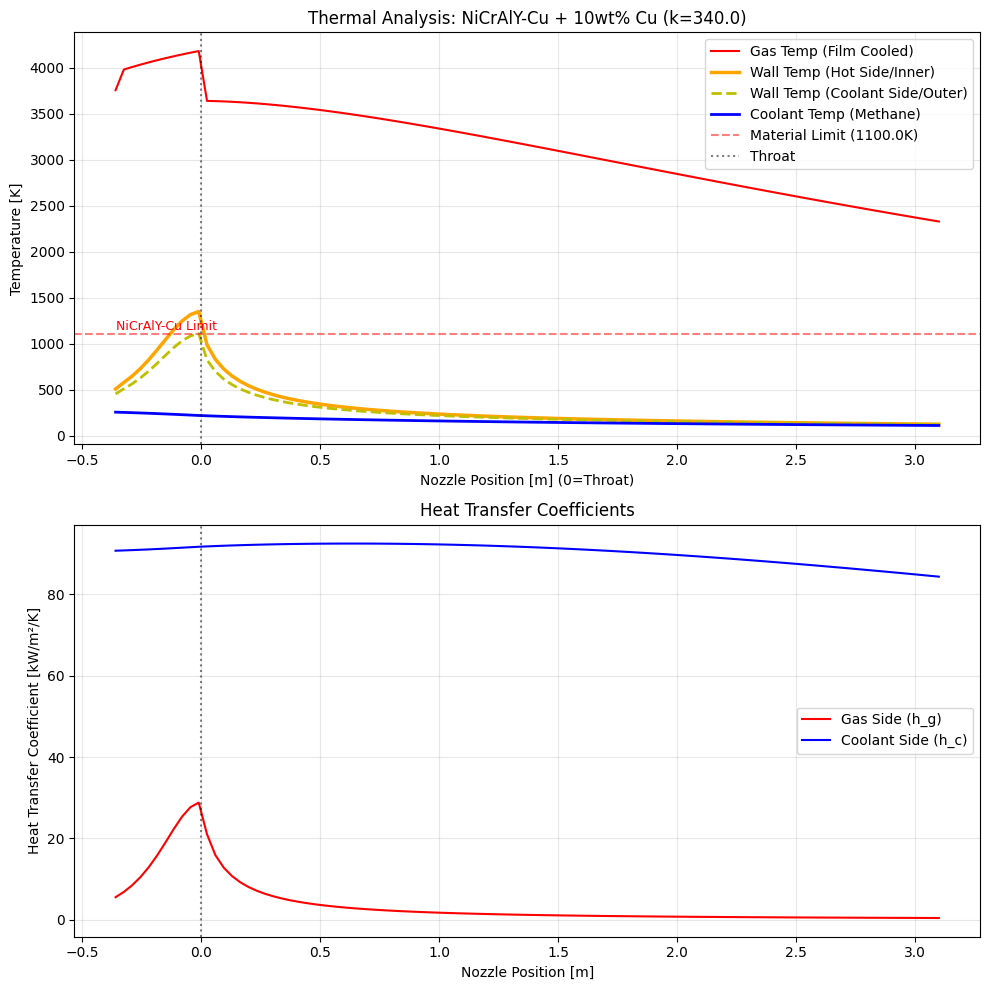

In [8]:
import cantera as ct
from CoolProp.CoolProp import PropsSI
import math
import numpy as np
import matplotlib.pyplot as plt

class FFSC_Thermal_Solver_FirstGen:
    def __init__(self):
        # --- [1] Target & Propellants ---
        self.thrust_kN = 2530.0
        self.pc_bar = 300.0
        self.of_ratio = 3.8
        self.fuel_name = "CH4"
        self.ox_name = "O2"
        self.mech_file = 'gri30.yaml'
        self.T_fuel_tank = 110.0
        self.isp_s = 342.1

        # --- [2] Cooling Settings ---
        self.film_cooling_pct = 6.0  # %

        # --- [3] Material: NiCrAlY-Cu + 10wt% Cu ---
        # 특성: 기존 Narloy-Z보다 높은 내열성 및 우수한 열전도율 가정
        self.wall_thickness_mm = 1.0  # 벽 두께
        self.k_wall = 340.0           # 열전도율 (W/mK, 고성능 구리 합금 수준)
        self.temp_limit_k = 1100.0    # 허용 온도 한계 (상향 조정)

        # --- [4] Geometry ---
        self.nozzle_length_m = 3.1
        self.epsilon = 106.0
        self.n_channels = 100
        self.w_channel_mm = 6.0
        self.h_channel_mm = 10.0

    def get_transport_properties(self, fluid, T_K, P_bar):
        try:
            rho = PropsSI('D', 'T', T_K, 'P', P_bar * 1e5, fluid)
            mu = PropsSI('V', 'T', T_K, 'P', P_bar * 1e5, fluid)
            cp = PropsSI('C', 'T', T_K, 'P', P_bar * 1e5, fluid)
            k = PropsSI('L', 'T', T_K, 'P', P_bar * 1e5, fluid)
            return rho, mu, cp, k
        except:
            return 350.0, 1.5e-5, 2500.0, 0.1

    def generate_nozzle_geometry(self, steps=100):
        """Rao Nozzle 근사 형상 생성 (초기 버전 로직)"""
        g0 = 9.81
        m_dot = (self.thrust_kN * 1000) / (self.isp_s * g0)
        c_star = 1800.0
        At = (m_dot * c_star) / (self.pc_bar * 1e5)
        Rt = math.sqrt(At / math.pi)
        Re = Rt * math.sqrt(self.epsilon)

        # Lengths
        L_conv = Rt * 3.0
        L_div = self.nozzle_length_m

        x = np.linspace(-L_conv, L_div, steps)
        r = []

        for xi in x:
            if xi < 0: # Converging
                ratio = xi / (-L_conv)
                ri = Rt + (Rt * 1.5) * (ratio**2)
            else: # Diverging
                ratio = xi / L_div
                ri = Rt + (Re - Rt) * (ratio**0.8) # Parabolic approximation
            r.append(ri)

        return x, np.array(r), m_dot

    def run_thermal_analysis(self):
        print(">>> Running Thermal Analysis (Full Detail)...")

        # 1. Setup Geometry
        steps = 100
        x_arr, r_arr, m_dot_total = self.generate_nozzle_geometry(steps)
        A_arr = np.pi * r_arr**2
        At = np.min(A_arr)

        # 2. Gas Properties
        gas = ct.Solution(self.mech_file)
        gas.TPX = 3600.0, self.pc_bar * 1e5, {self.fuel_name: 1.0, self.ox_name: self.of_ratio}
        gas.equilibrate('HP')
        T_comb = gas.T
        c_star = 1800.0
        mu_gas = 8e-5
        Pr_gas = 0.7
        Cp_gas = gas.cp_mass

        # 3. Initialize Arrays
        T_g_arr = []
        h_g_arr = []
        T_wall_hot_arr = np.zeros(steps)
        T_wall_cold_arr = np.zeros(steps) # Added Outer Wall
        T_cool_arr = np.zeros(steps)
        h_cool_arr = np.zeros(steps)

        # 4. Gas Side Heat Transfer (Original Simplified Model)
        for i in range(steps):
            # Local Heat Transfer Coeff (Bartz)
            Dt = 2 * math.sqrt(At/math.pi)
            h_g_throat = 0.026 / (Dt**0.2) * ( (mu_gas**0.2 * Cp_gas)/(Pr_gas**0.6) ) * ((self.pc_bar*1e5 / c_star)**0.8)
            h_g = h_g_throat * ((At / A_arr[i])**0.9)

            # Film Cooling Decay Model
            dist = x_arr[i] - x_arr[0]
            decay = math.exp(-1.5 * (dist - (-0.2))) if dist > 0 else 1.0
            T_film_reduction = (T_comb - 300) * (self.film_cooling_pct/100.0) * 3.0 * decay

            T_gas_effective = T_comb - T_film_reduction

            # Simplified Isentropic Temp Drop
            if x_arr[i] > 0:
                expansion_factor = 1.0 + 1.5 * (x_arr[i] / x_arr[-1])
                T_gas_effective = T_gas_effective / (1 + 0.15 * expansion_factor**2)

            T_g_arr.append(T_gas_effective)
            h_g_arr.append(h_g)

        # 5. Coolant Side (Counter-Flow)
        T_cool_curr = self.T_fuel_tank
        P_cool_curr = 500.0
        m_dot_cool = m_dot_total / (1 + self.of_ratio)

        A_chan = (self.w_channel_mm/1000) * (self.h_channel_mm/1000)
        D_hyd = 4 * A_chan / (2 * ((self.w_channel_mm+self.h_channel_mm)/1000))

        # Backward Loop (Exit -> Throat -> Chamber)
        for i in range(steps-1, -1, -1):
            rho_c, mu_c, cp_c, k_c = self.get_transport_properties("Methane", T_cool_curr, P_cool_curr)

            u_cool = m_dot_cool / (self.n_channels * rho_c * A_chan)

            # Gnielinski
            Re = rho_c * u_cool * D_hyd / mu_c
            Pr = mu_c * cp_c / k_c
            f = (0.79 * math.log(max(Re, 1000)) - 1.64)**(-2)
            Nu = ((f/8)*(Re-1000)*Pr) / (1 + 12.7*math.sqrt(f/8)*(Pr**(2/3)-1))
            h_c = Nu * k_c / D_hyd

            # Overall Heat Transfer with NEW Material Conductivity
            t_wall = self.wall_thickness_mm / 1000.0
            k_wall = self.k_wall # 340.0 applied here

            U_overall = 1.0 / (1.0/h_g_arr[i] + t_wall/k_wall + 1.0/h_c)
            q_flux = U_overall * (T_g_arr[i] - T_cool_curr)

            # Calculate Wall Temp
            T_wall_hot = T_g_arr[i] - q_flux / h_g_arr[i] # Inner Wall (Gas side)
            T_wall_cold = T_cool_curr + q_flux / h_c      # Outer Wall (Coolant side)

            T_cool_arr[i] = T_cool_curr
            T_wall_hot_arr[i] = T_wall_hot
            T_wall_cold_arr[i] = T_wall_cold
            h_cool_arr[i] = h_c

            # Update Coolant Temp
            if i > 0:
                dx = x_arr[i] - x_arr[i-1]
                area_segment = 2 * math.pi * r_arr[i] * dx
                heat_input = q_flux * area_segment
                dT_cool = heat_input / (m_dot_cool * cp_c)
                T_cool_curr += dT_cool

        # 6. Plotting
        self.plot_results(x_arr, T_g_arr, T_wall_hot_arr, T_wall_cold_arr, T_cool_arr, h_g_arr, h_cool_arr)

    def plot_results(self, x, T_g, T_wh, T_wc, T_c, h_g, h_c):
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

        # [Top] Temperature Profile
        ax1.plot(x, T_g, 'r-', label="Gas Temp (Film Cooled)", linewidth=1.5)
        # Wall Temps
        ax1.plot(x, T_wh, 'orange', label="Wall Temp (Hot Side/Inner)", linewidth=2.5)
        ax1.plot(x, T_wc, 'y--', label="Wall Temp (Coolant Side/Outer)", linewidth=2.0)

        ax1.plot(x, T_c, 'b-', label="Coolant Temp (Methane)", linewidth=2)

        # New Material Limit Line
        ax1.axhline(y=self.temp_limit_k, color='r', linestyle='--', alpha=0.5, label=f'Material Limit ({self.temp_limit_k}K)')
        ax1.text(x[0], self.temp_limit_k + 50, "NiCrAlY-Cu Limit", color='r', fontsize=9)

        ax1.axvline(x=0, color='k', linestyle=':', alpha=0.5, label='Throat')

        ax1.set_xlabel("Nozzle Position [m] (0=Throat)")
        ax1.set_ylabel("Temperature [K]")
        ax1.set_title(f"Thermal Analysis: NiCrAlY-Cu + 10wt% Cu (k={self.k_wall})")
        ax1.legend(loc='upper right')
        ax1.grid(alpha=0.3)

        # [Bottom] HTC
        ax2.plot(x, np.array(h_g)/1000, 'r-', label="Gas Side (h_g)")
        ax2.plot(x, np.array(h_c)/1000, 'b-', label="Coolant Side (h_c)")
        ax2.set_xlabel("Nozzle Position [m]")
        ax2.set_ylabel("Heat Transfer Coefficient [kW/m²/K]")
        ax2.legend()
        ax2.set_title("Heat Transfer Coefficients")
        ax2.grid(alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.show()

# --- Execution ---
if __name__ == "__main__":
    solver = FFSC_Thermal_Solver_FirstGen()
    try:
        solver.run_thermal_analysis()
    except Exception as e:
        print(f"Error: {e}")

In [9]:
import math

class TurbopumpSizing:
    def __init__(self, thrust_tf, isp, pc_bar, of_ratio):
        self.F = thrust_tf * 1000 * 9.80665  # N
        self.Isp = isp
        self.Pc = pc_bar * 1e5  # Pa
        self.OF = of_ratio
        self.g0 = 9.80665

        # Propellant properties (Subcooling)
        self.rho_ox = 1141  # kg/m^3 (LOX)
        self.rho_fuel = 422  # kg/m^3 (LCH4)

        # Efficiency and coefficients
        self.eta_p = 0.75  # pump efficiency
        self.psi = 0.55    # Head Coefficient
        self.phi = 0.10    # Flow Coefficient
        self.Nss_limit_suction = 12000 # US Units limit for suction performance without inducer
        self.Nss_limit_inducer = 25000 # US Units limit with inducer

        self.results = {}

    def calculate_mass_flow(self):
        # 1. Calculate mass flow rate
        m_total = self.F / (self.Isp * self.g0)
        m_ox = m_total * (self.OF / (self.OF + 1))
        m_fuel = m_total * (1 / (self.OF + 1))

        self.results['Mass Flow Total (kg/s)'] = m_total
        self.results['Mass Flow Ox (kg/s)'] = m_ox
        self.results['Mass Flow Fuel (kg/s)'] = m_fuel

        return m_ox, m_fuel

    def size_component(self, name, m_dot, rho, pressure_drop_cooling_bar, npsh_available_m=60):
        """
        Sizing calculation for a specific pump component (Fuel or Oxidizer)
        """
        # 2. Calculate required pump pressure
        # Pressure buildup: Tank -> Pump -> Cooling (Fuel only) -> Injector -> Chamber
        # We need Pump Discharge Pressure > Chamber Pressure + Drops

        P_cham = self.Pc
        dP_main_inj = 0.20 * P_cham  # Injector differential pressure (20% of Pc)

        # Preburner & Turbine pressure drops are simplified for sizing
        # Assuming Pump Discharge needs to overcome Chamber + Injector + Cooling
        # In FFSC, preburners are high pressure, close to pump discharge.

        P_discharge = P_cham + dP_main_inj + (pressure_drop_cooling_bar * 1e5)
        dP_pump = P_discharge # Simplified: Assuming tank pressure is negligible compared to discharge

        Q = m_dot / rho # m^3/s
        Power_pump = (dP_pump * Q) / self.eta_p

        self.results[f'{name} Discharge P (bar)'] = P_discharge / 1e5
        self.results[f'{name} Pump Power (MW)'] = Power_pump / 1e6

        # 3. Decide RPM based on Suction Performance (Nss)
        # Nss = N(rpm) * sqrt(Q(gpm)) / NPSH(ft)^0.75

        Q_gpm = Q * 15850 # m^3/s to GPM
        NPSH_ft = npsh_available_m * 3.281 # m to ft

        # We target the high limit of Nss to maximize RPM (smaller pump), assuming an inducer is used.
        target_Nss = 15000 # Conservative target with inducer

        N_rpm = (target_Nss * (NPSH_ft)**0.75) / math.sqrt(Q_gpm)
        omega = N_rpm * 2 * math.pi / 60 # rad/s

        self.results[f'{name} RPM'] = N_rpm
        self.results[f'{name} Target Nss'] = target_Nss

        # 4. Impeller Sizing (Head Coefficient)
        # Head H = dP / (rho * g)
        H = dP_pump / (rho * self.g0) # m

        # psi = gH / u_tip^2  -> u_tip = sqrt(gH / psi)
        u_tip = math.sqrt(self.g0 * H / self.psi) # m/s
        D_impeller = 2 * u_tip / omega # m

        self.results[f'{name} Impeller Dia (mm)'] = D_impeller * 1000
        self.results[f'{name} Tip Speed (m/s)'] = u_tip

        # 5. Cavitation Check
        # Calculate actual Nss based on chosen RPM (which was derived from Nss, so it matches)
        # But we check against limits.

        cavitation_risk = "Low (Standard Design)"
        if target_Nss > 20000:
            cavitation_risk = "High (Requires Advanced Inducer)"
        elif target_Nss > 12000:
            cavitation_risk = "Medium (Requires Inducer)"

        self.results[f'{name} Cavitation Risk'] = cavitation_risk

        # 6. Bearing Selection (DN Factor)
        # Estimate Shaft Diameter based on Torque or simple relation to Impeller D
        # Assumption: Bearing Bore ~ 30% of Impeller Diameter
        D_bearing_mm = D_impeller * 1000 * 0.30

        DN = D_bearing_mm * N_rpm
        self.results[f'{name} Bearing DN'] = DN

        bearing_rec = ""
        if DN < 1000000:
            bearing_rec = "Standard Steel Ball/Roller Bearings (Grease/Oil)"
        elif DN < 2000000:
            bearing_rec = "High Precision Ceramic/Hybrid Bearings (Oil Jet/Mist)"
        else:
            bearing_rec = "Fluid Film / Hydrostatic Bearings (Limit Exceeded for Rolling Element)"

        self.results[f'{name} Bearing Recommendation'] = bearing_rec

    def run(self):
        m_ox, m_fuel = self.calculate_mass_flow()
        print("-" * 60)
        print(f"Turbopump Sizing Results (Thrust={self.F/1000/9.80665:.0f} ton, Pc={self.Pc/1e5:.0f} bar)")
        print("-" * 60)

        # Design LOX pump (Low cooling drop)
        self.size_component("Oxidizer", m_ox, self.rho_ox, pressure_drop_cooling_bar=30, npsh_available_m=40)

        # Design Fuel(CH4) pump (High cooling drop)
        self.size_component("Fuel", m_fuel, self.rho_fuel, pressure_drop_cooling_bar=100, npsh_available_m=60)

        # Print Results cleanly
        for key, value in self.results.items():
            if isinstance(value, float):
                print(f"{key:<40}: {value:.2f}")
            else:
                print(f"{key:<40}: {value}")
        print("-" * 60)

# Example Usage
if __name__ == "__main__":
    # Example: 230 ton thrust, 352s Isp, 300 bar Pc, 3.6 OF
    tp = TurbopumpSizing(thrust_tf=253, isp=352.7, pc_bar=300, of_ratio=3.6)
    tp.run()

------------------------------------------------------------
Turbopump Sizing Results (Thrust=253 ton, Pc=300 bar)
------------------------------------------------------------
Mass Flow Total (kg/s)                  : 717.32
Mass Flow Ox (kg/s)                     : 561.38
Mass Flow Fuel (kg/s)                   : 155.94
Oxidizer Discharge P (bar)              : 390.00
Oxidizer Pump Power (MW)                : 25.58
Oxidizer RPM                            : 6586.27
Oxidizer Target Nss                     : 15000
Oxidizer Impeller Dia (mm)              : 722.89
Oxidizer Tip Speed (m/s)                : 249.29
Oxidizer Cavitation Risk                : Medium (Requires Inducer)
Oxidizer Bearing DN                     : 1428337.27
Oxidizer Bearing Recommendation         : High Precision Ceramic/Hybrid Bearings (Oil Jet/Mist)
Fuel Discharge P (bar)                  : 460.00
Fuel Pump Power (MW)                    : 22.66
Fuel RPM                                : 10300.83
Fuel Target Nss    

In [10]:
# 실행
design = TurbopumpSizing(thrust_tf=258, isp=335.1, pc_bar=300, of_ratio=3.8)
results = design.run()

for k, v in results.items():
    print(f"{k}: {v:.2f}")

------------------------------------------------------------
Turbopump Sizing Results (Thrust=258 ton, Pc=300 bar)
------------------------------------------------------------
Mass Flow Total (kg/s)                  : 769.92
Mass Flow Ox (kg/s)                     : 609.52
Mass Flow Fuel (kg/s)                   : 160.40
Oxidizer Discharge P (bar)              : 390.00
Oxidizer Pump Power (MW)                : 27.78
Oxidizer RPM                            : 6320.85
Oxidizer Target Nss                     : 15000
Oxidizer Impeller Dia (mm)              : 753.24
Oxidizer Tip Speed (m/s)                : 249.29
Oxidizer Cavitation Risk                : Medium (Requires Inducer)
Oxidizer Bearing DN                     : 1428337.27
Oxidizer Bearing Recommendation         : High Precision Ceramic/Hybrid Bearings (Oil Jet/Mist)
Fuel Discharge P (bar)                  : 460.00
Fuel Pump Power (MW)                    : 23.31
Fuel RPM                                : 10156.61
Fuel Target Nss    

AttributeError: 'NoneType' object has no attribute 'items'